# **MIT 6.S965 Fall 2022: Lab 1 Pruning**


This colab notebook provides code and a framework for ***Lab 1 Pruning***. You can work out your solutions here.



Please fill out this [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeM7P6OU0gzcgLpQCSh-UvDIKO1hvbuk291nLLG-x-R2FPBSQ/viewform?vc=0&c=0&w=1&flr=0&usp=mail_form_link) when you finished this lab. We would love to hear your thoughts or feedback on how we can improve this lab!

## Goals

In this assignment, you will practice pruning a classical neural network model to reduce both model size and latency. The goals of this assignment are as follows:

- Understand the basic concept of **pruning**
- Implement and apply **fine-grained pruning**
- Implement and apply **channel pruning**
- Get a basic understanding of performance improvement (such as speedup) from pruning
- Understand the differences and tradeoffs between these pruning approaches

## Contents

There are two main sections in this lab: ***Fine-grained Pruning*** and ***Channel Pruning***.

There are ***9*** questions in total:
- For *Fine-grained Pruning*, there are ***5*** questions (Question 1-5).
- For *Channel Pruning*, there are ***3*** questions (Question 6-8).
- Question 9 compares fine-grained pruning and channel pruning.

# Setup

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [1]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [4]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [5]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [6]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader, 
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False, 
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.) 

In [7]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

Define misc functions for verification.

Load the pretrained model and the CIFAR-10 dataset.

In [8]:
checkpoint_url = "https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [9]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


# Let's First Evaluate the Accuracy and Model Size of Dense Model

In [10]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
dense model has size=35.20 MiB


# Let's see the distribution of weight values

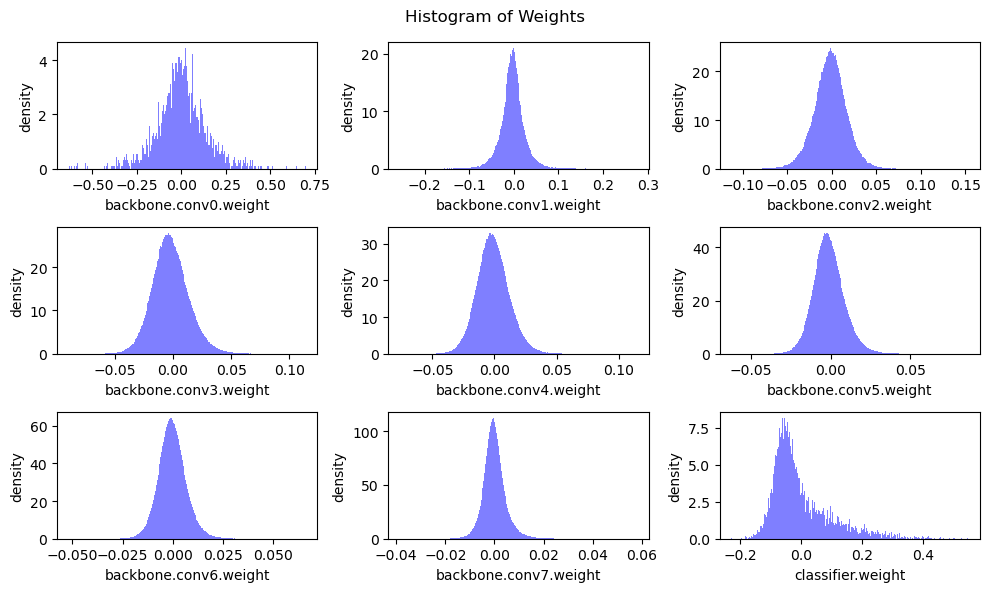

In [11]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

## \#Parameters of each layer
In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

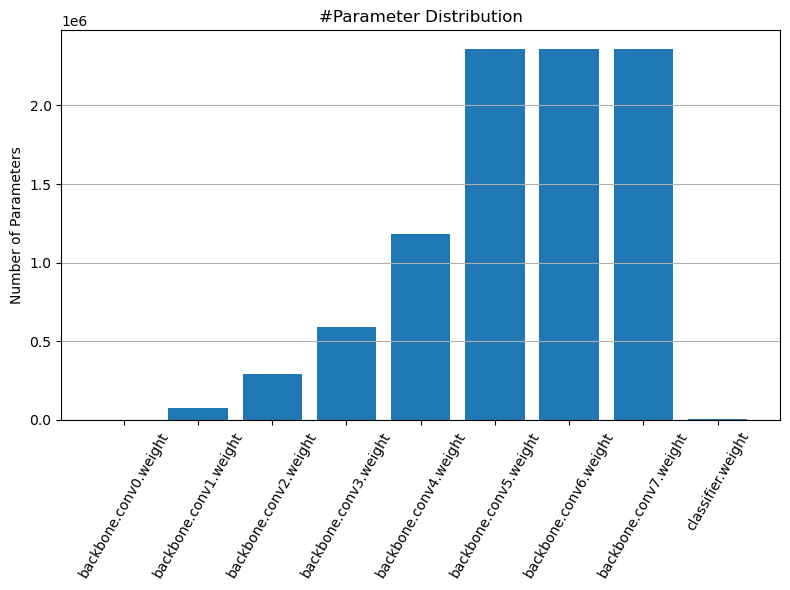

In [12]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution



# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [13]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%


## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.

### Question 6 (10 pts)

Please complete the following functions for channel pruning.

Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [14]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return int(round(channels * (1. - prune_ratio)))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module, 
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep])
        ##################### YOUR CODE ENDS HERE #####################

    return model


Run the following cell to perform a sanity check to make sure the implementation is correct.

In [15]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate. 

As you may see, directly removing 30% of the channels leads to low accuracy.

In [16]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=28.15%


## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

### Question 7 (15 pts)
Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [17]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.norm(channel_weight)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True) 

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )
        
        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(
            torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [18]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is 
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.95%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.95%
* Check passed.


Finally, we compare the pruned models' accuracy with and without sorting.

In [19]:
channel_pruning_ratio = 0.0  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=92.95%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=92.95%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [20]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 92.92% / Best Accuracy: 92.92%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 92.86% / Best Accuracy: 92.92%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 92.93% / Best Accuracy: 92.93%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 92.84% / Best Accuracy: 92.93%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 92.97% / Best Accuracy: 92.97%


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [21]:
# helper functions to measure latency of a regular PyTorch models. 
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)', 
                            round(original_latency * 1000, 1), 
                            round(pruned_latency * 1000, 1), 
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)', 
                            round(original_macs / 1e6), 
                            round(pruned_macs / 1e6), 
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)', 
                            round(original_param / 1e6, 2), 
                            round(pruned_param / 1e6, 2), 
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    16.6            17.9            0.9            
MACs (M)        606             606             1.0            
Param (M)       9.23            9.23            1.0            


In [22]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [23]:
net=copy.deepcopy(pruned_model)
#net=copy.deepcopy(model)
#net=copy.deepcopy(finegrainedprunedmodel)
net.to('cpu')

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [24]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import torch.nn as nn
import torch.nn.functional as F

In [25]:
batch_size=24
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


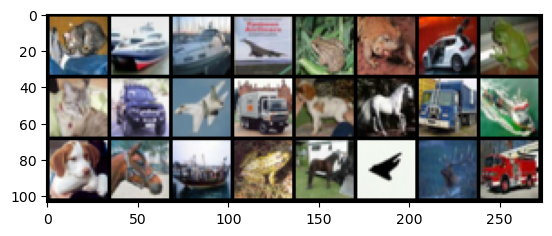

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck
Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  frog   dog horse  ship  frog horse plane  deer truck


In [32]:

def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Approximation delta:  tensor([0.0682], dtype=torch.float64)
Original Image
Predicted: cat  Probability: 1.0


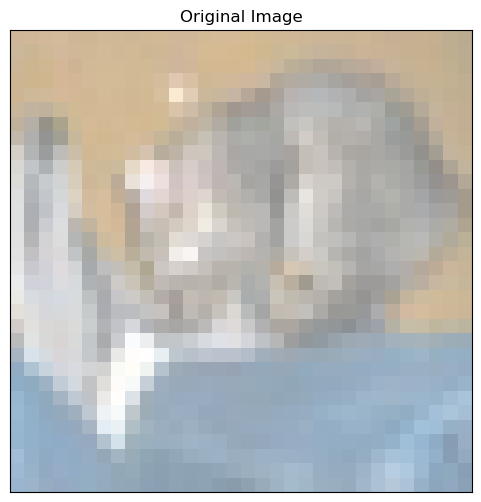

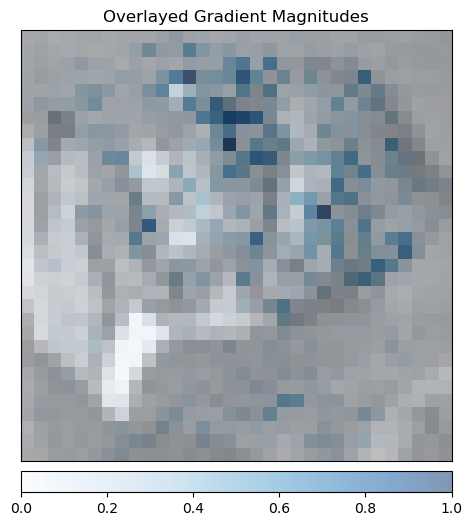

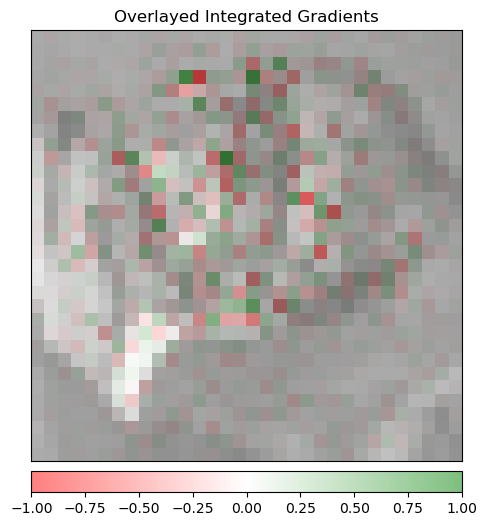

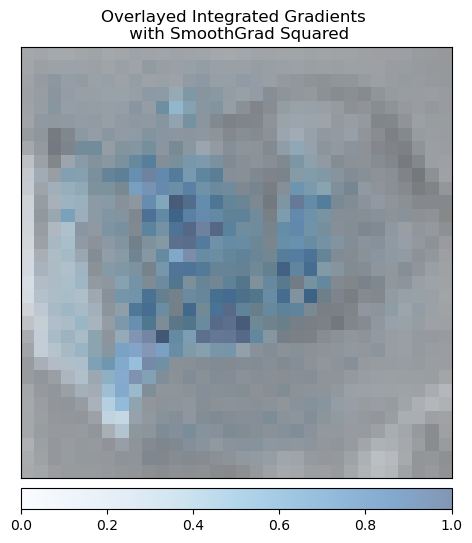

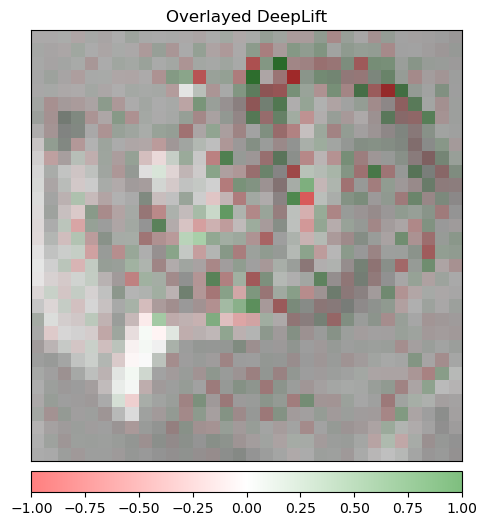

In [33]:
ind = 0

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.2758], dtype=torch.float64)
Original Image
Predicted: ship  Probability: 1.0


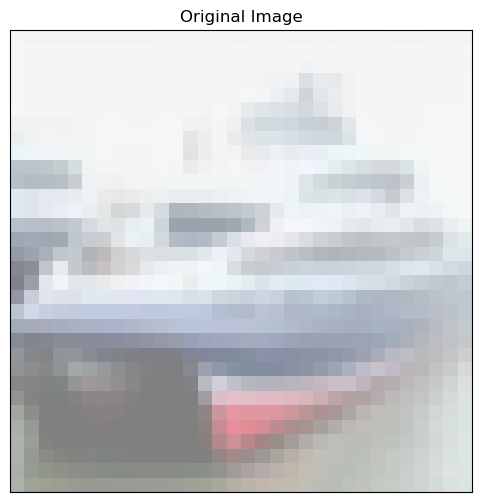

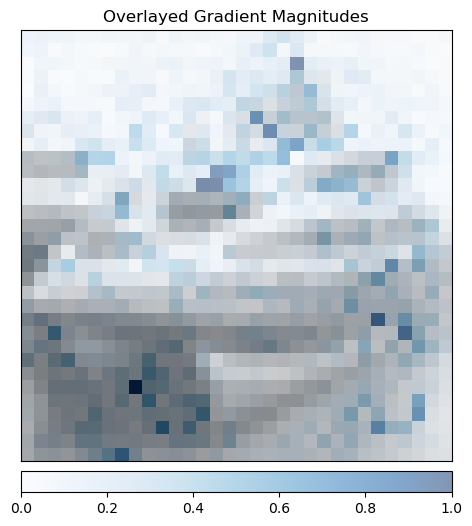

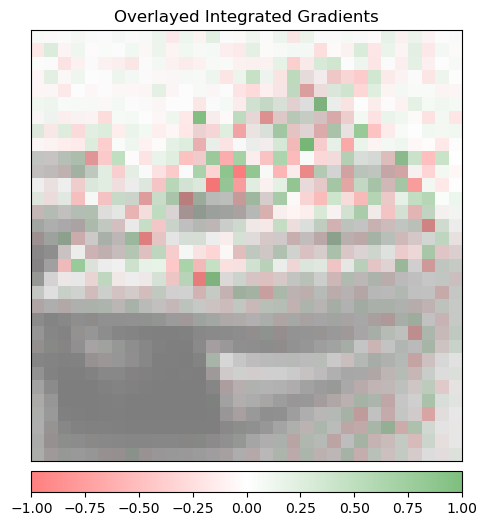

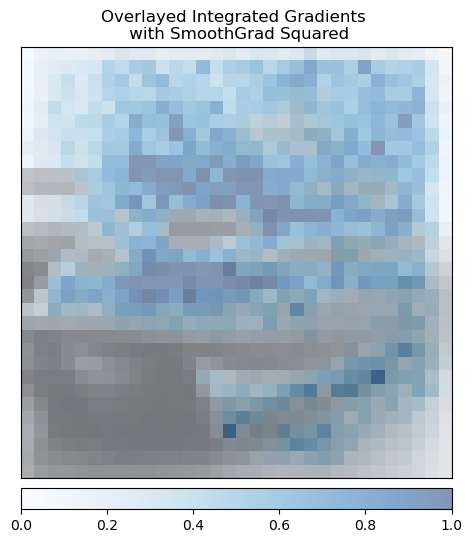

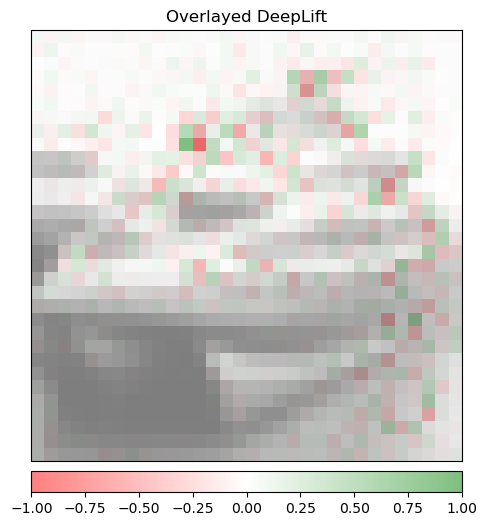

In [28]:
ind = 1

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.1834], dtype=torch.float64)
Original Image
Predicted: ship  Probability: 1.0


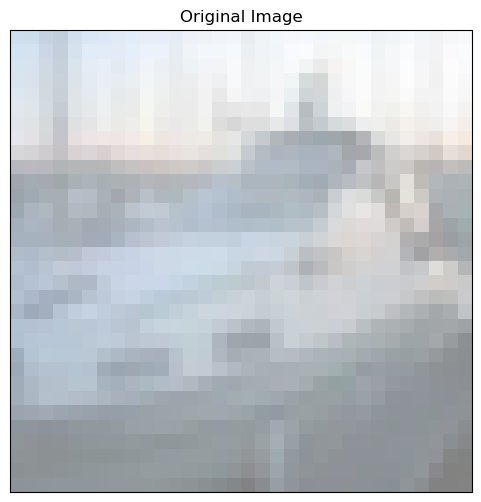

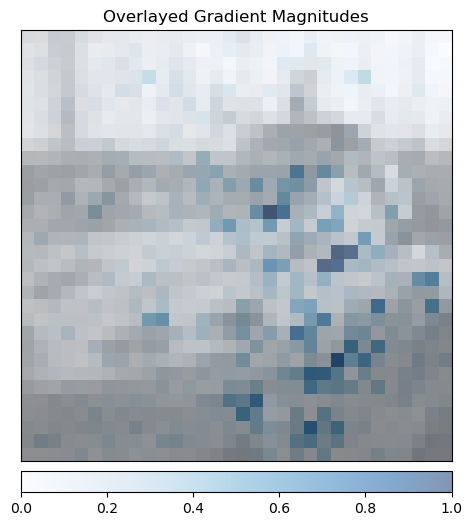

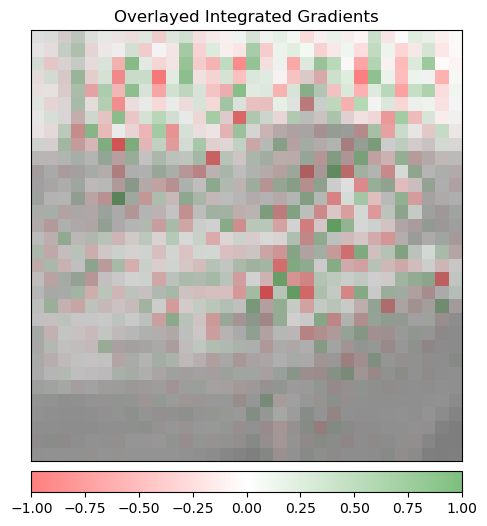

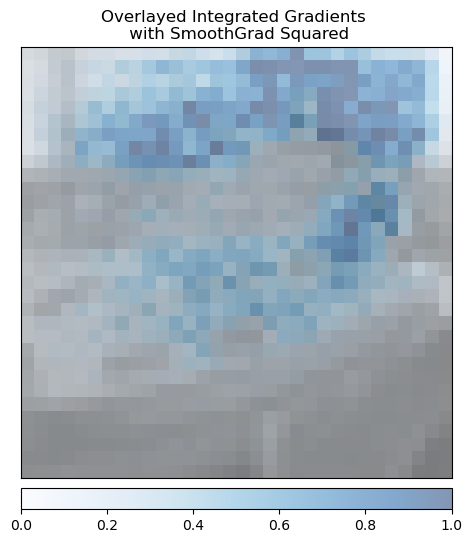

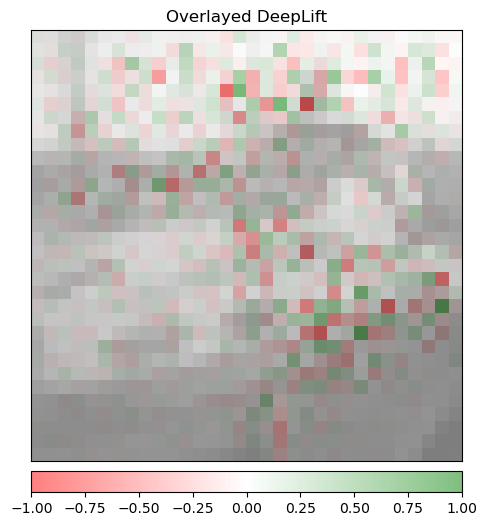

In [29]:
ind = 2

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0988], dtype=torch.float64)
Original Image
Predicted: plane  Probability: 1.0


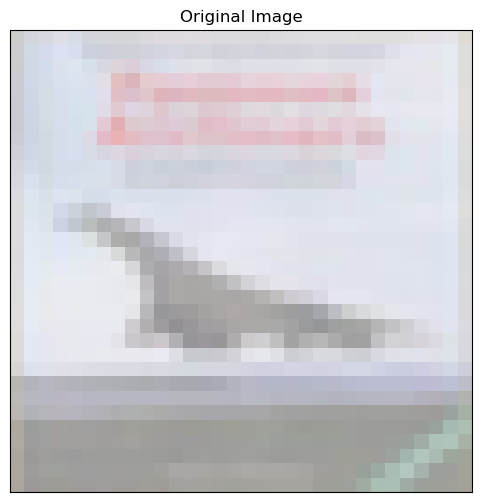

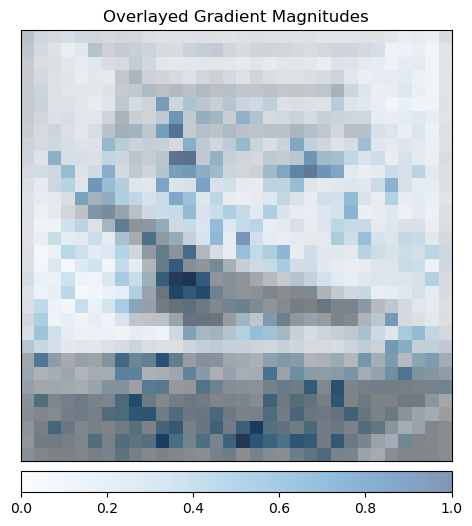

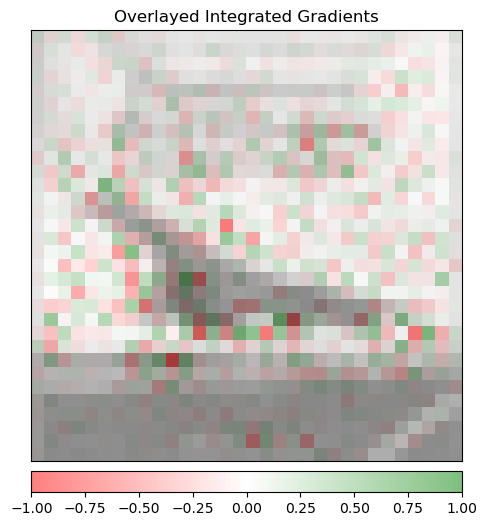

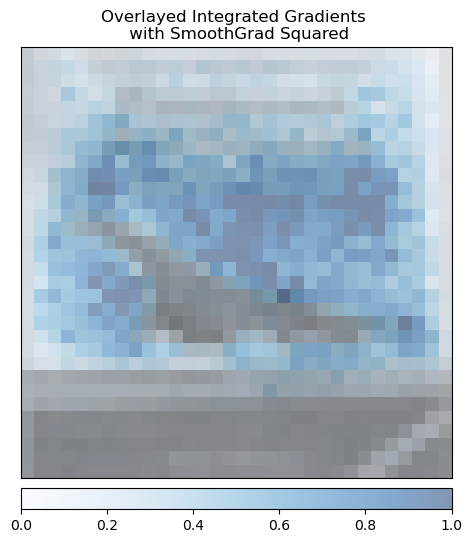

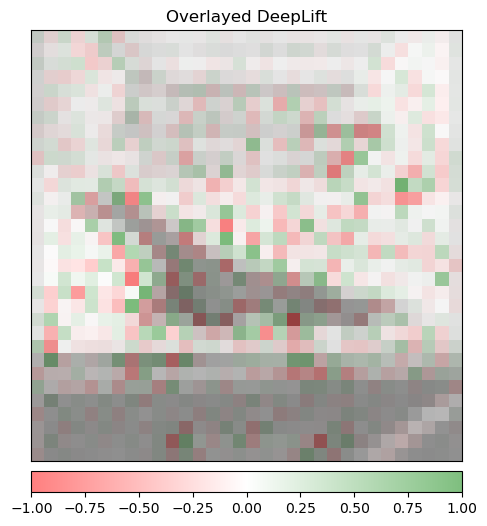

In [30]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.1022], dtype=torch.float64)
Original Image
Predicted: frog  Probability: 1.0


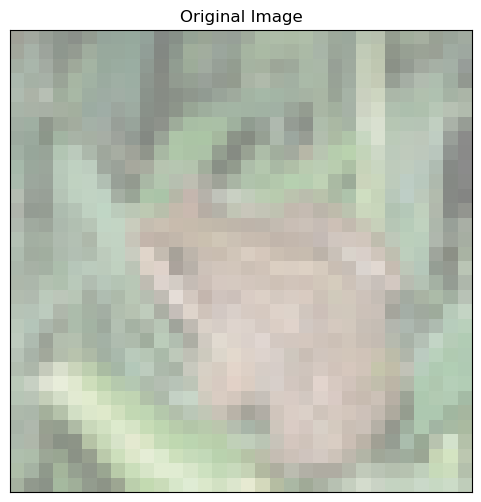

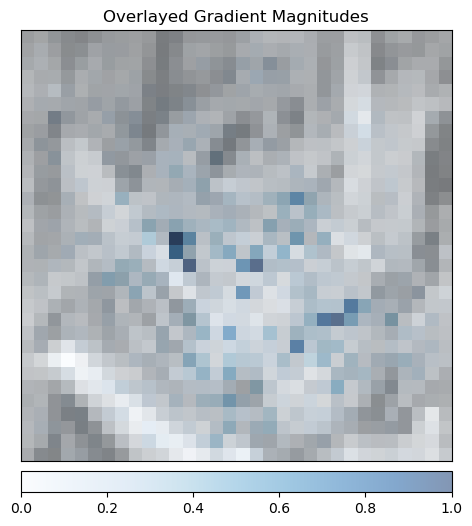

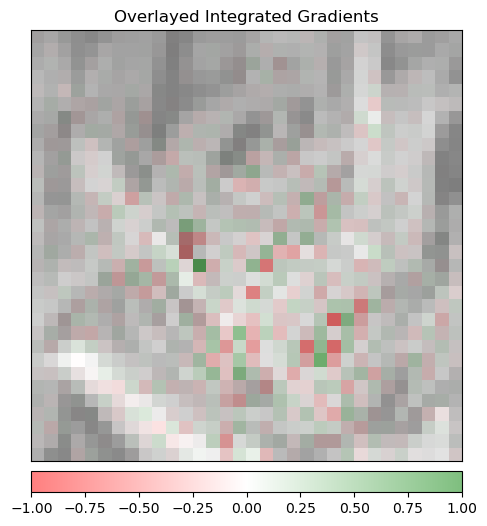

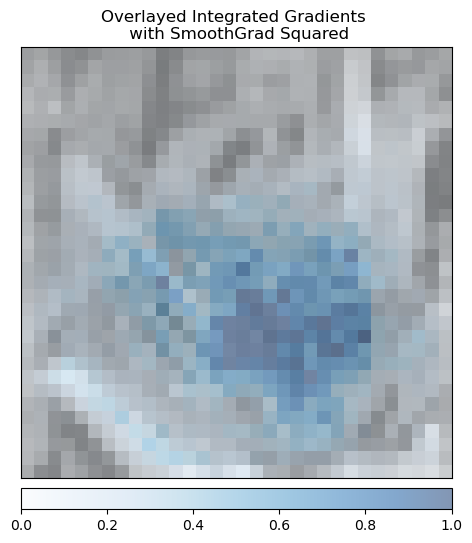

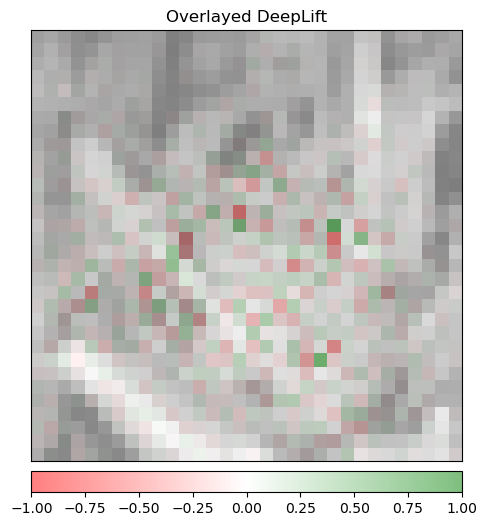

In [34]:
ind = 4

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0829], dtype=torch.float64)
Original Image
Predicted: frog  Probability: 1.0


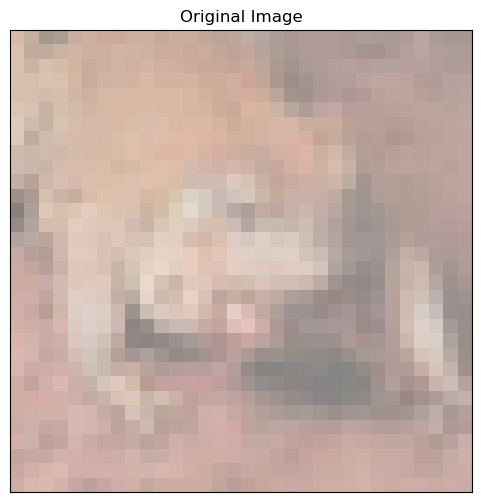

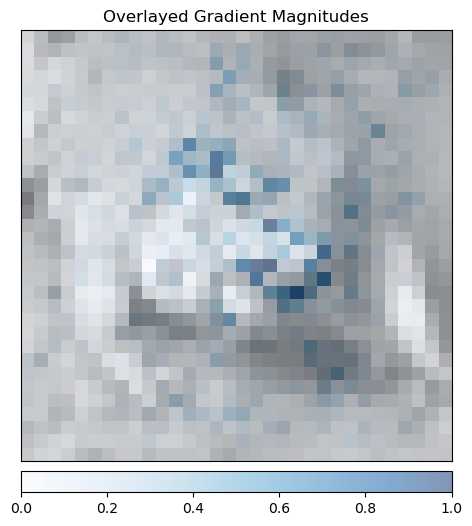

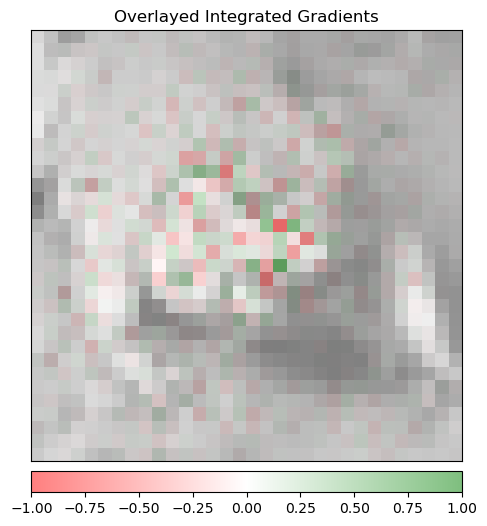

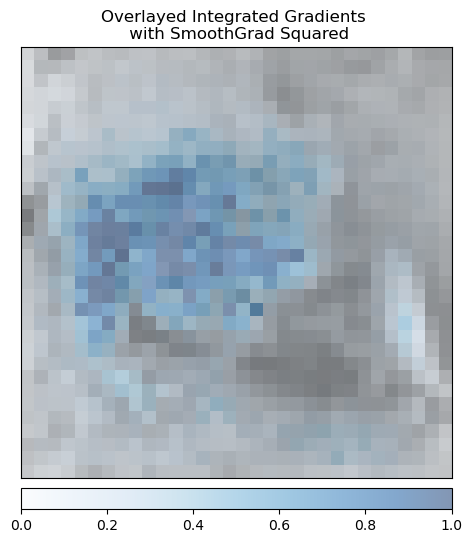

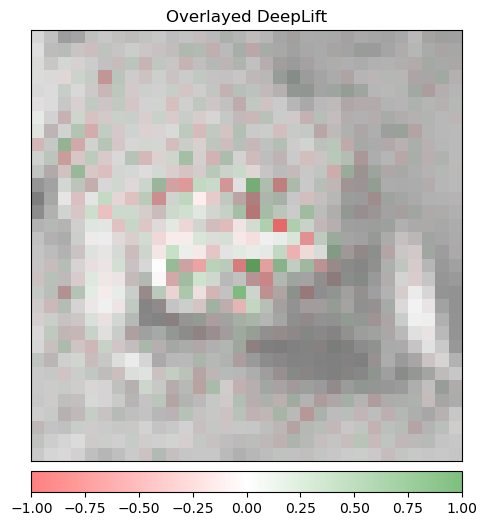

In [35]:
ind = 5

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0049], dtype=torch.float64)
Original Image
Predicted: car  Probability: 1.0


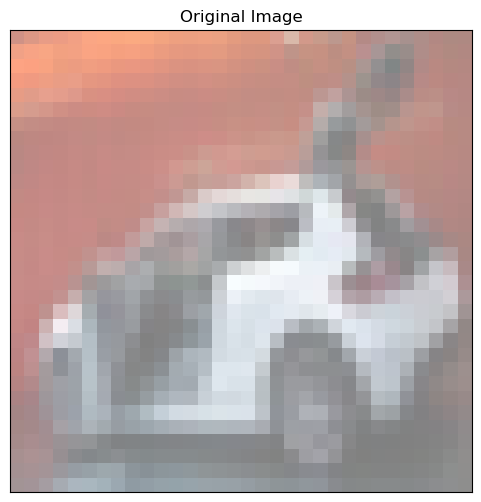

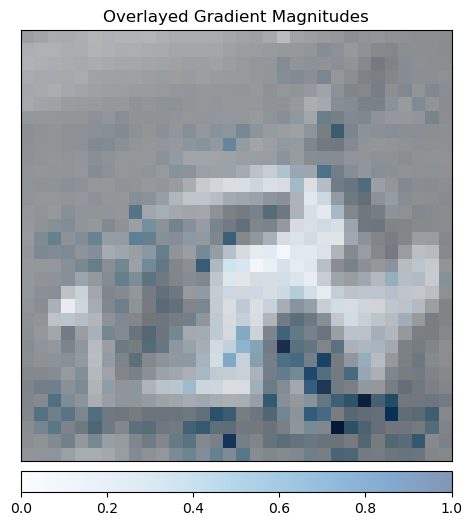

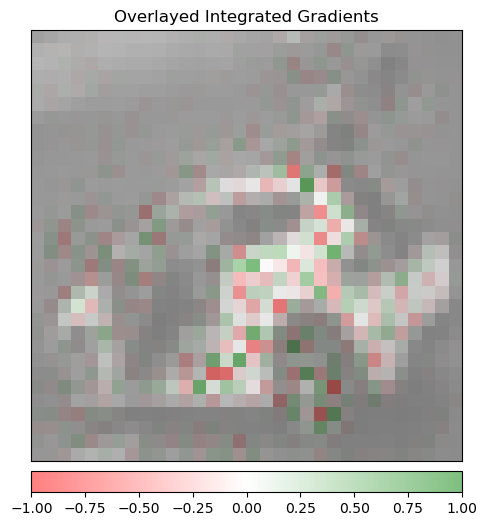

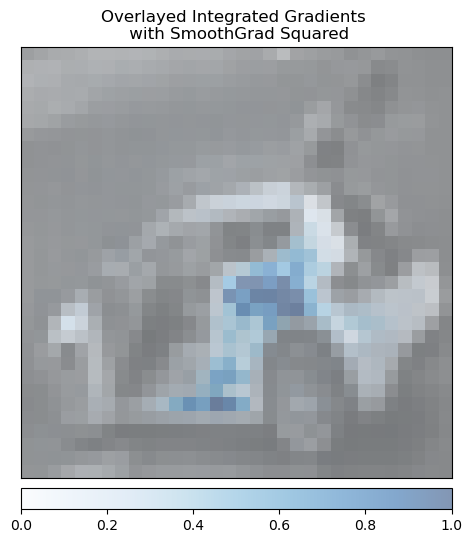

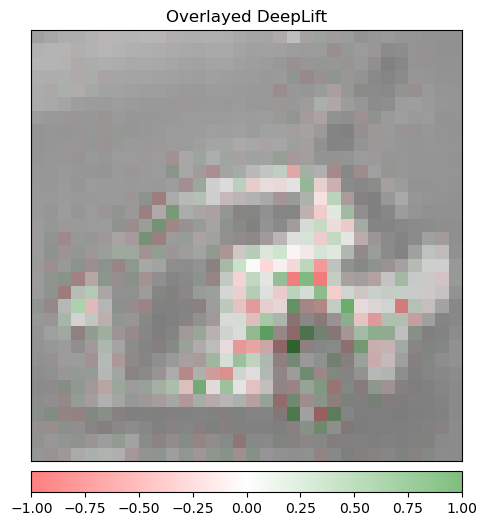

In [36]:
ind = 6

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0191], dtype=torch.float64)
Original Image
Predicted: frog  Probability: 1.0


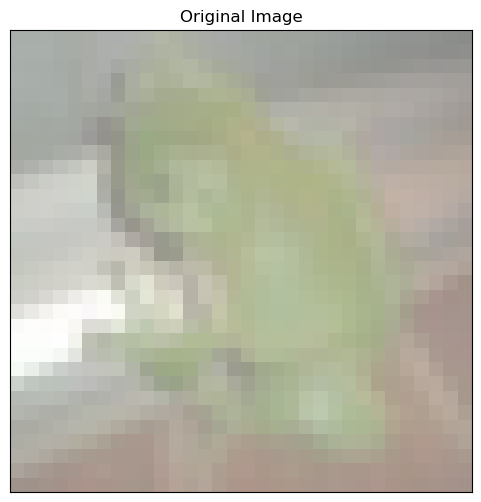

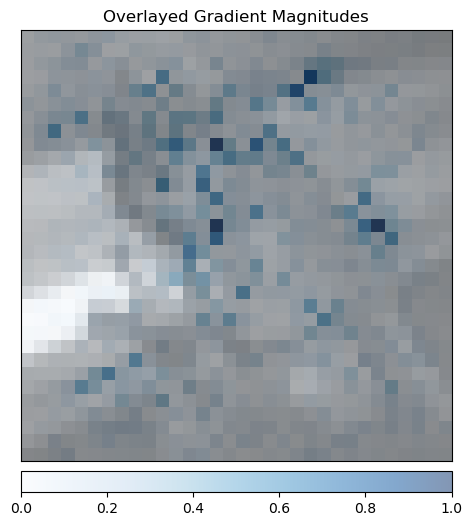

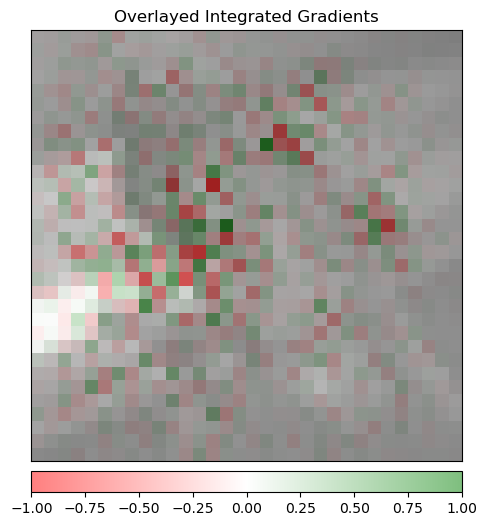

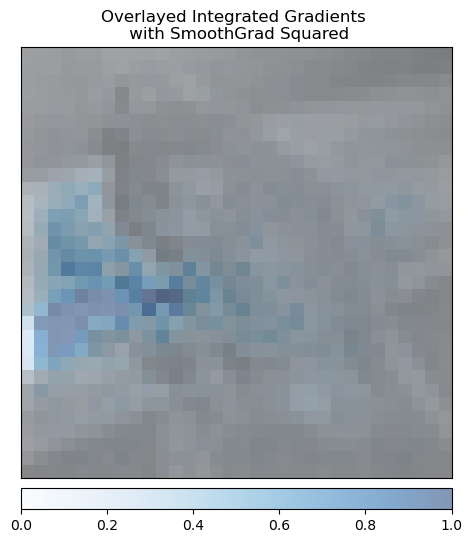

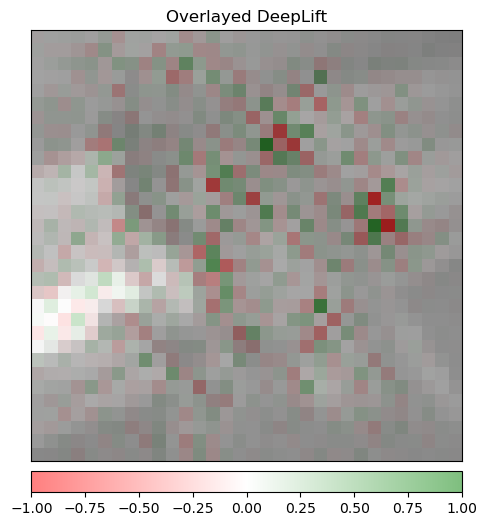

In [37]:
ind = 7

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.2420], dtype=torch.float64)
Original Image
Predicted: cat  Probability: 1.0


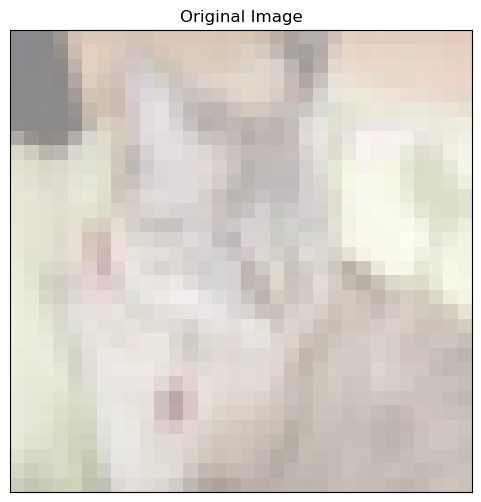

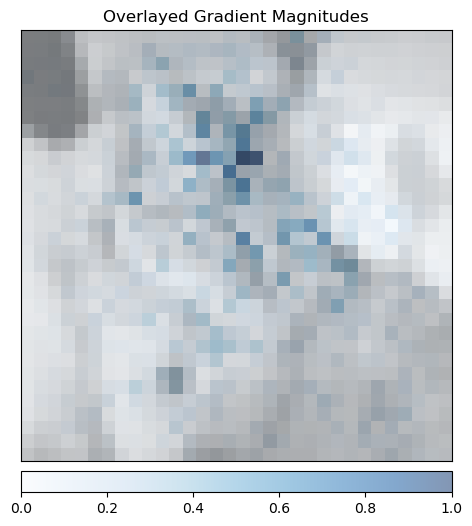

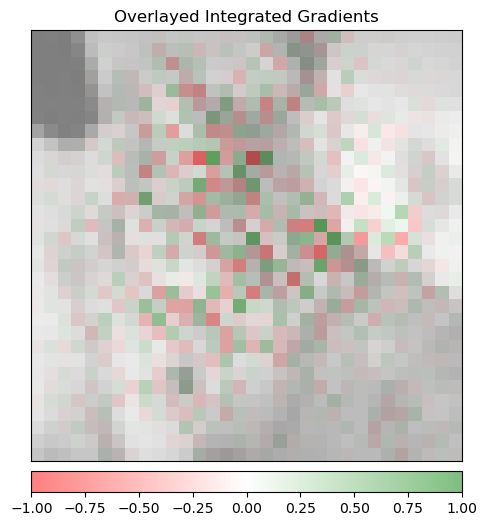

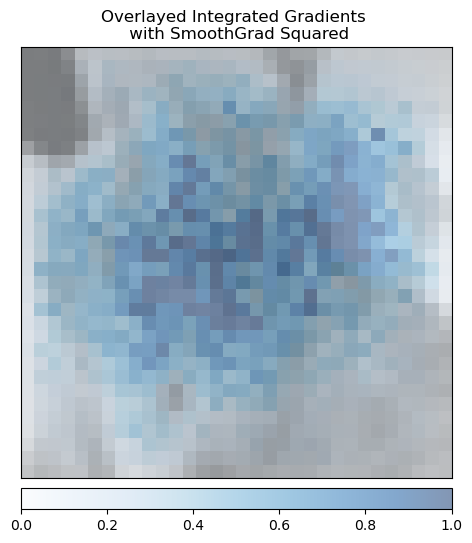

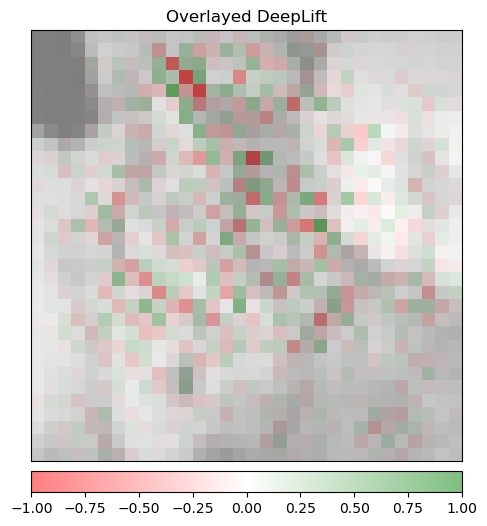

In [38]:
ind = 8

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0417], dtype=torch.float64)
Original Image
Predicted: car  Probability: 1.0


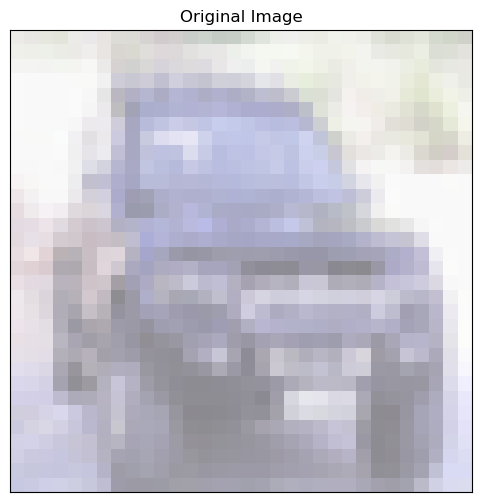

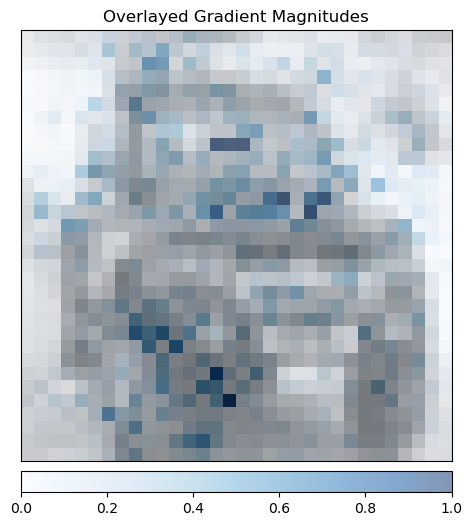

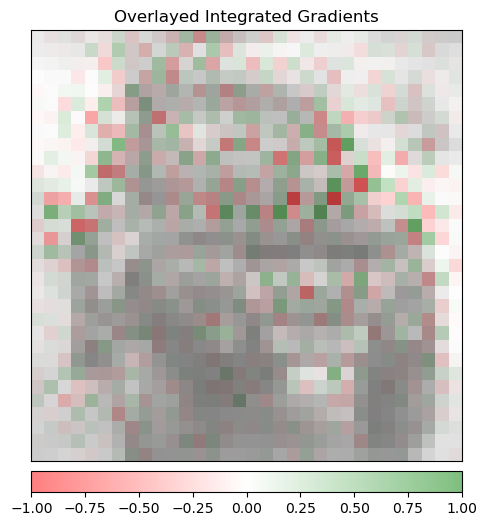

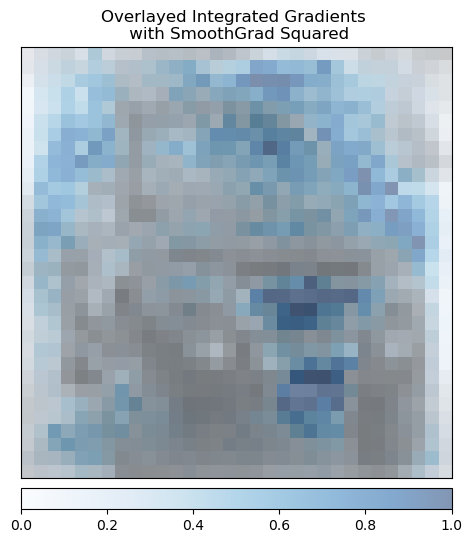

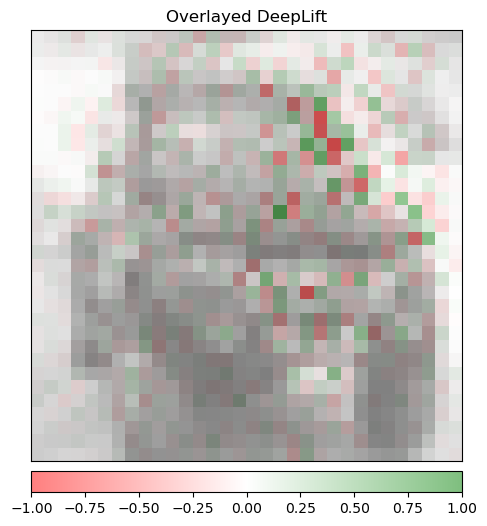

In [39]:
ind = 9

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0645], dtype=torch.float64)
Original Image
Predicted: plane  Probability: 1.0


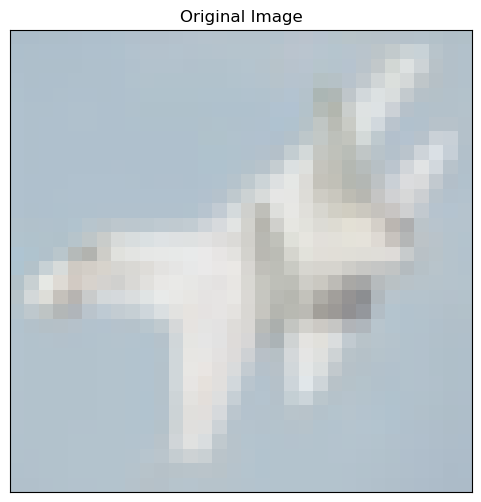

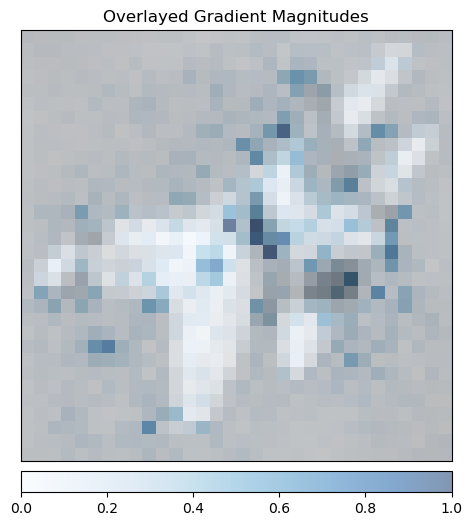

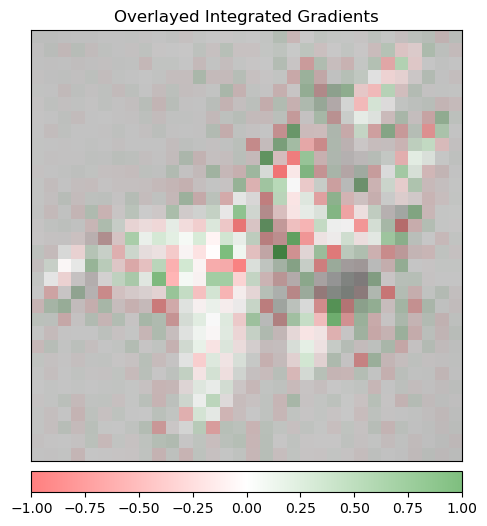

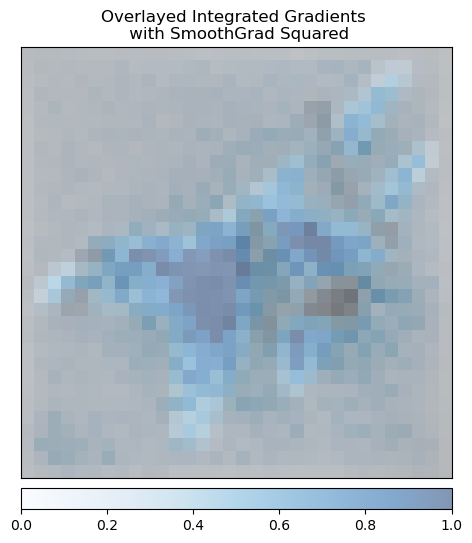

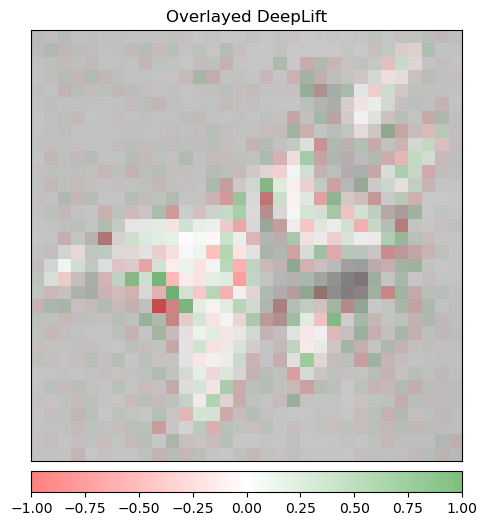

In [40]:
ind = 10

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.1969], dtype=torch.float64)
Original Image
Predicted: truck  Probability: 1.0


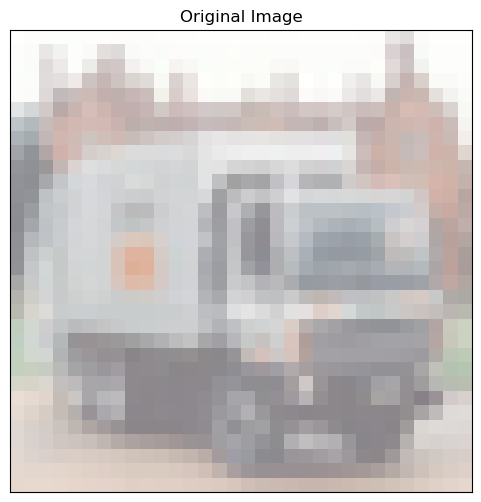

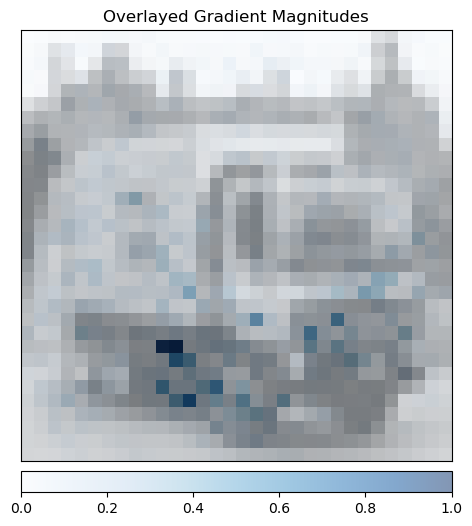

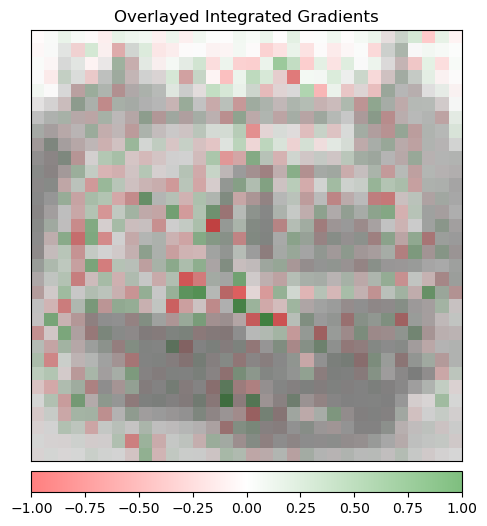

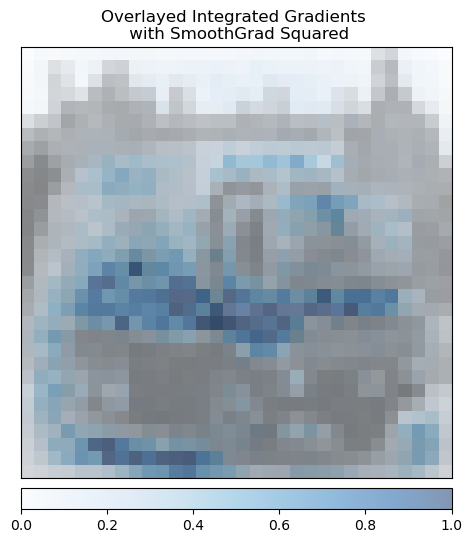

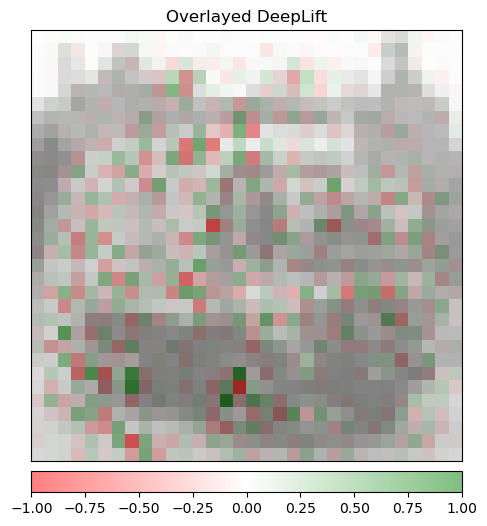

In [41]:
ind = 11

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.1551], dtype=torch.float64)
Original Image
Predicted: dog  Probability: 1.0


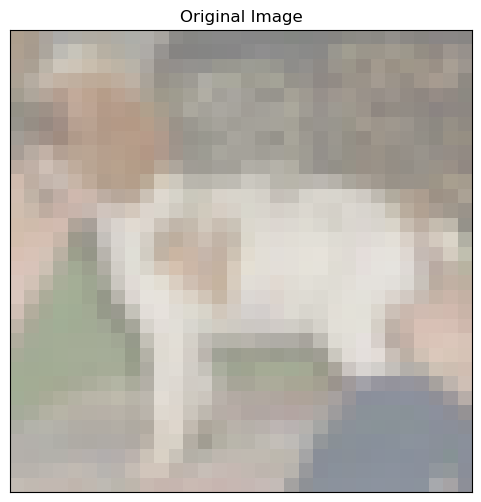

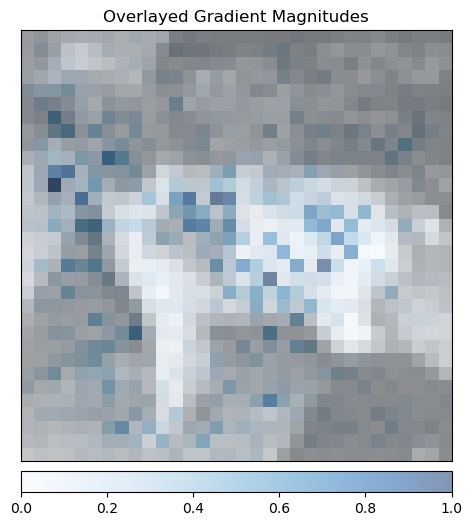

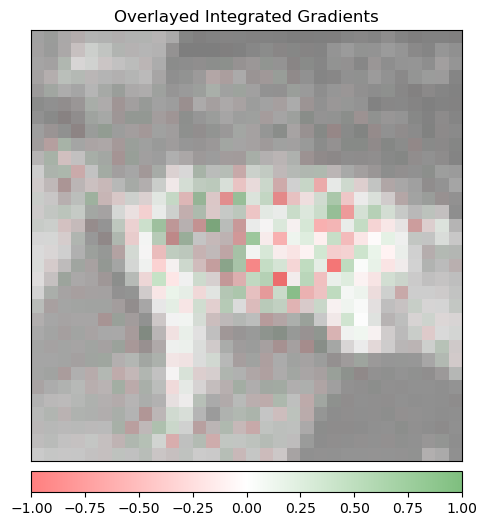

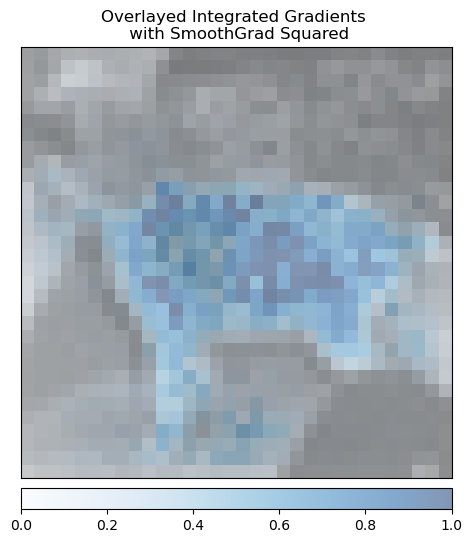

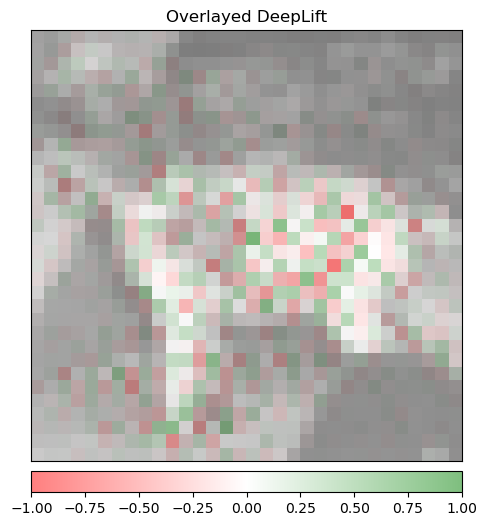

In [42]:
ind = 12

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0185], dtype=torch.float64)
Original Image
Predicted: horse  Probability: 1.0


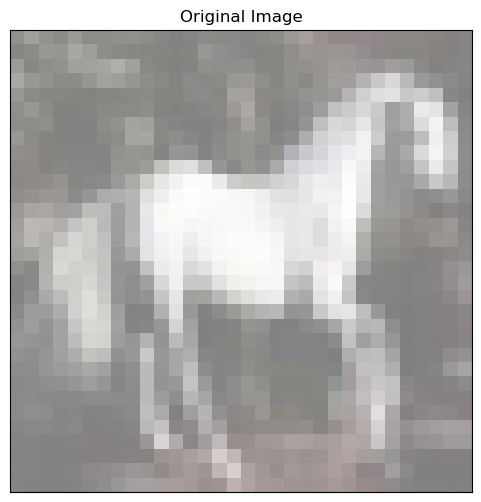

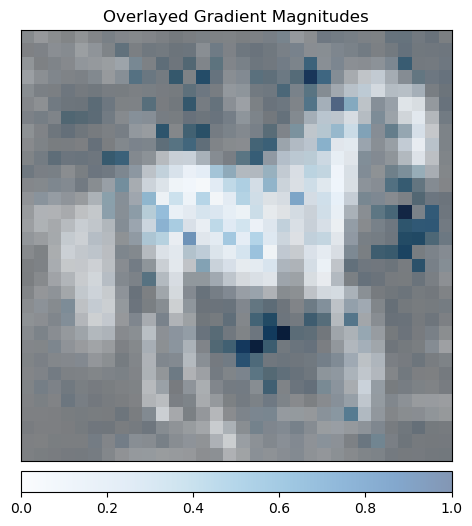

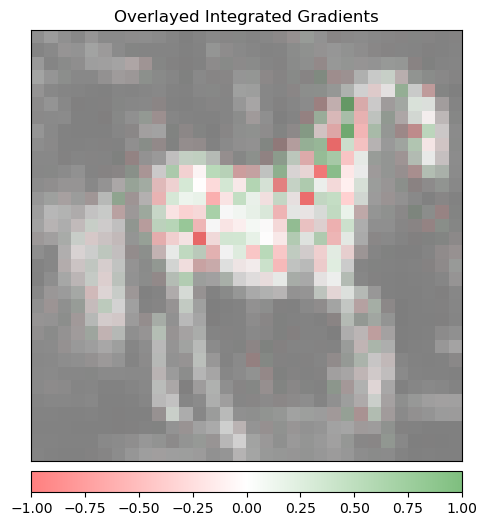

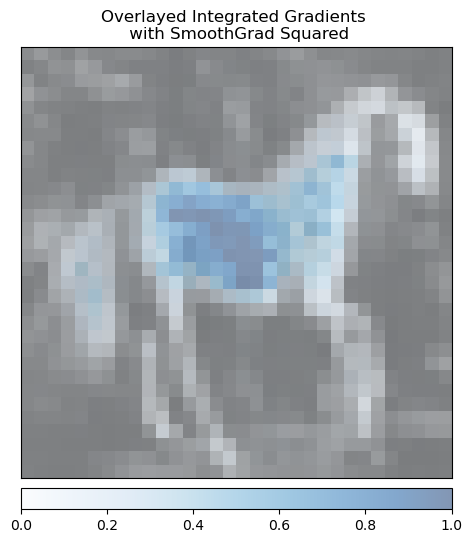

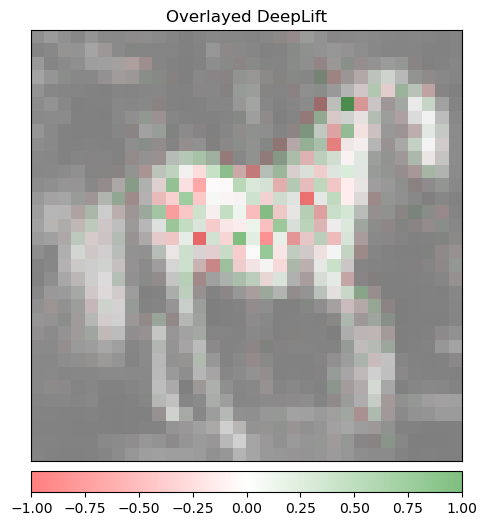

In [43]:
ind = 13

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.1103], dtype=torch.float64)
Original Image
Predicted: truck  Probability: 1.0


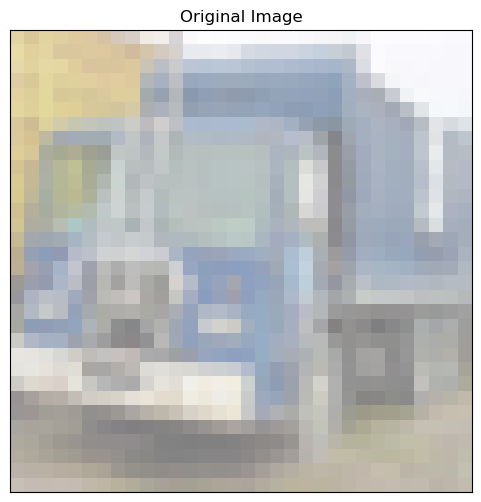

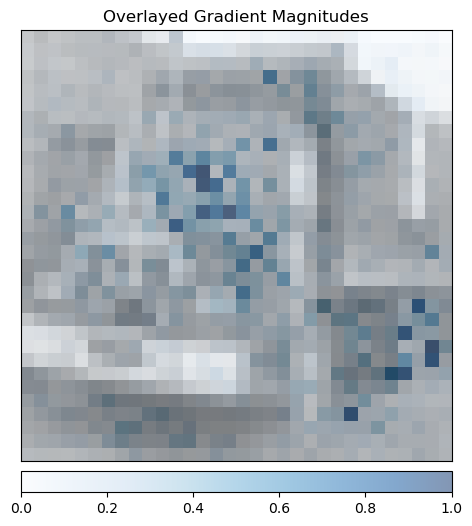

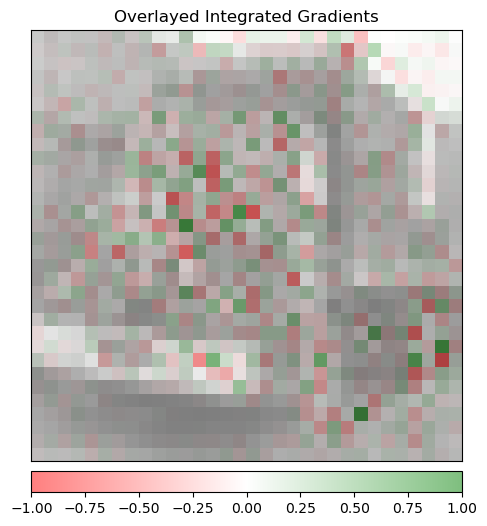

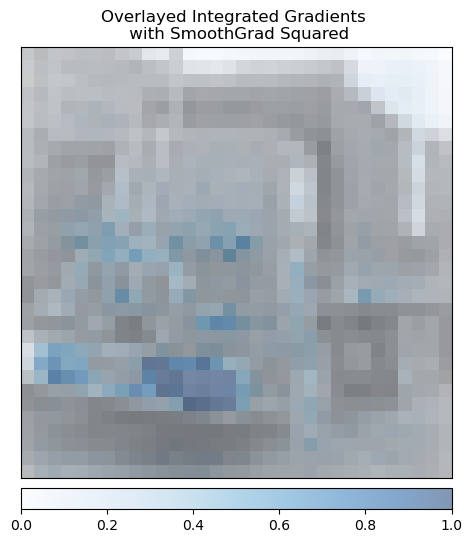

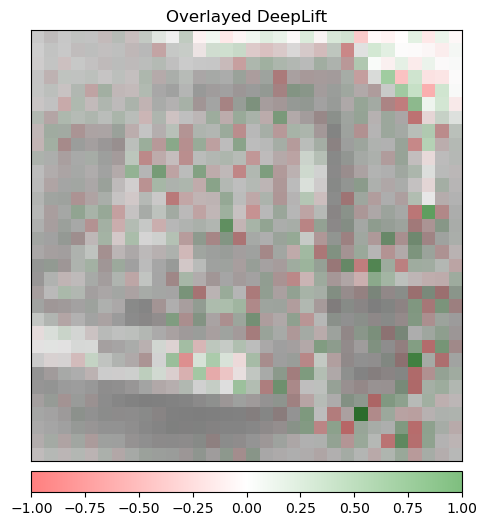

In [44]:
ind = 14

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')

Approximation delta:  tensor([0.0477], dtype=torch.float64)
Original Image
Predicted: frog  Probability: 1.0


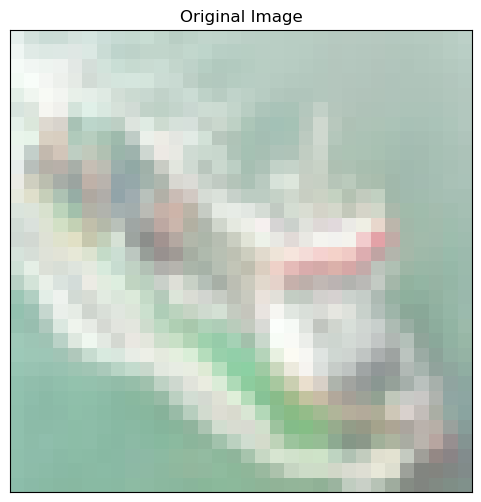

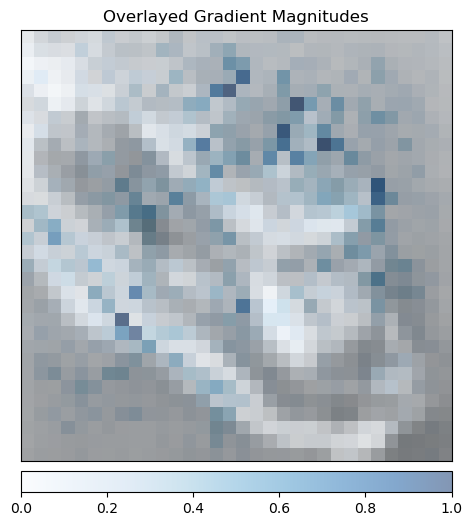

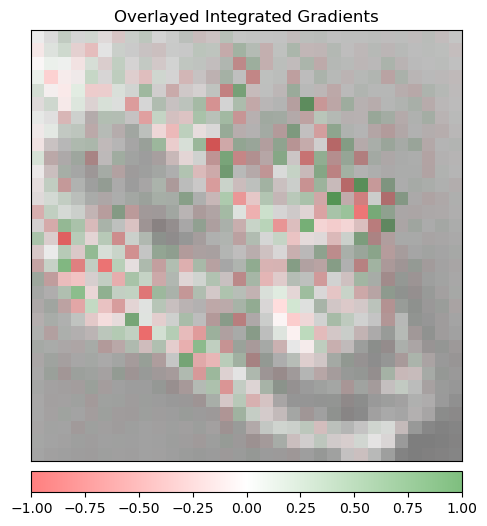

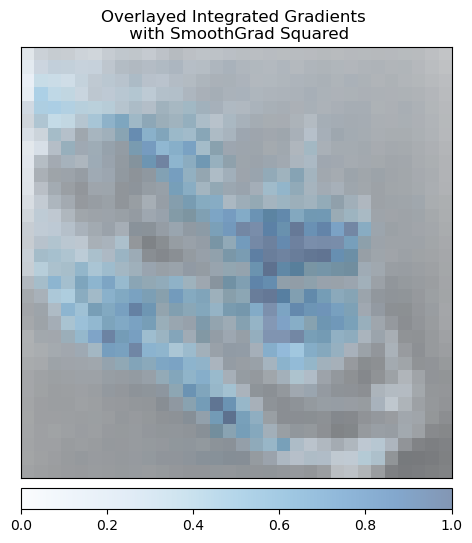

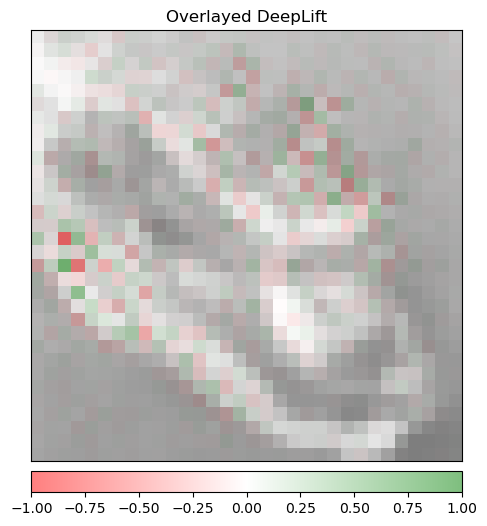

In [45]:
ind = 15

input = images[ind].unsqueeze(0)
input.requires_grad = True

net.eval()

def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )

    return tensor_attributions

saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', classes[predicted[ind]],
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_1 = viz.visualize_image_attr(None, original_image,
                      method="original_image", title="Original Image")

_2 = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_3 = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_4 = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value",
                             outlier_perc=10, show_colorbar=True,
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_5 = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True,
                          title="Overlayed DeepLift")


_1[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Original Image.jpg')

_2[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Gradient Magnitudes.jpg')

_3[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients.jpg')

_4[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed Integrated Gradients with SmoothGrad Squared.jpg')

_5[0].savefig('visualize_image/'+str(ind)+'pruning'+str(channel_pruning_ratio)+'-Overlayed DeepLift.jpg')